# **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import re
import requests
from io import StringIO
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tabulate import tabulate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# **Ensure Using GPU**

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Running on {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Running on CPU")


Running on Tesla T4


# **Load Dataset**

In [3]:
def load_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    arabic_sentences = []
    english_sentences = []

    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            arabic, english = parts[1], parts[0]  # Swapped for AR to EN
            arabic_sentences.append(arabic)
            english_sentences.append(english)
    return arabic_sentences, english_sentences

filepath = "/kaggle/input/arabic-data/ara_.txt"
arabic_sentences, english_sentences = load_data(filepath)

# **Visualize Data**

╒═════╤══════════╤═══════════╕
│   # │ Arabic   │ English   │
╞═════╪══════════╪═══════════╡
│   1 │ مرحبًا.   │ Hi.       │
├─────┼──────────┼───────────┤
│   2 │ اركض!    │ Run!      │
├─────┼──────────┼───────────┤
│   3 │ النجدة!  │ Help!     │
├─────┼──────────┼───────────┤
│   4 │ اقفز!    │ Jump!     │
├─────┼──────────┼───────────┤
│   5 │ قف!      │ Stop!     │
├─────┼──────────┼───────────┤
│   6 │ داوم.    │ Go on.    │
├─────┼──────────┼───────────┤
│   7 │ استمر.   │ Go on.    │
├─────┼──────────┼───────────┤
│   8 │ مرحباً.   │ Hello!    │
├─────┼──────────┼───────────┤
│   9 │ تعجّل!    │ Hurry!    │
├─────┼──────────┼───────────┤
│  10 │ استعجل!  │ Hurry!    │
╘═════╧══════════╧═══════════╛


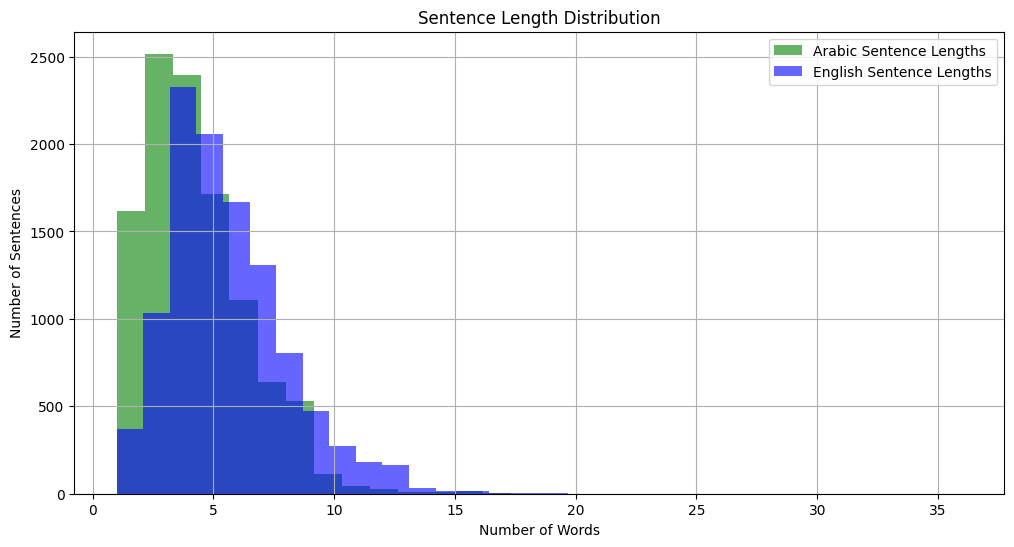

In [4]:
# Visualize Data
def visualize_pairs(arabic_sentences, english_sentences, num_samples=10):
    data = []
    for i in range(min(num_samples, len(arabic_sentences))):
        data.append([i+1, arabic_sentences[i], english_sentences[i]])
    
    print(tabulate(data, headers=["#", "Arabic", "English"], tablefmt="fancy_grid"))

def visualize_lengths(arabic_sentences, english_sentences):
    ar_lengths = [len(sentence.split()) for sentence in arabic_sentences]
    en_lengths = [len(sentence.split()) for sentence in english_sentences]

    plt.figure(figsize=(12, 6))
    plt.hist(ar_lengths, bins=30, alpha=0.6, label='Arabic Sentence Lengths', color='green')
    plt.hist(en_lengths, bins=30, alpha=0.6, label='English Sentence Lengths', color='blue')
    plt.title('Sentence Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Number of Sentences')
    plt.legend()
    plt.grid(True)
    plt.savefig('sentence_length_distribution.png')

visualize_pairs(arabic_sentences, english_sentences)
visualize_lengths(arabic_sentences, english_sentences)

# **Build Vocabulary**

In [5]:
# Text Preprocessing
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

def build_vocabulary(sentences, min_freq=2):
    word_counts = {}
    for sentence in sentences:
        for word in sentence.split():
            word_counts[word] = word_counts.get(word, 0) + 1
    
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    idx = 4
    for word, count in word_counts.items():
        if count >= min_freq and word not in vocab:
            vocab[word] = idx
            idx += 1
    return vocab

ar_cleaned = [clean_text(sent) for sent in arabic_sentences]
en_cleaned = [clean_text(sent) for sent in english_sentences]

ar_vocab = build_vocabulary(ar_cleaned)
en_vocab = build_vocabulary(en_cleaned)

# **Convert sentences to indices**

In [6]:
def sentence_to_indices(sentence, vocab):
    tokens = ['<sos>'] + sentence.strip().split() + ['<eos>']
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

ar_indices = [sentence_to_indices(sent, ar_vocab) for sent in ar_cleaned]
en_indices = [sentence_to_indices(sent, en_vocab) for sent in en_cleaned]


# **Use custom data into a PyTorch DataLoader**

In [7]:
class TranslationDataset(Dataset):
    def __init__(self, src_indices, tgt_indices):
        self.src_indices = src_indices
        self.tgt_indices = tgt_indices

    def __len__(self):
        return len(self.src_indices)

    def __getitem__(self, idx):
        return self.src_indices[idx], self.tgt_indices[idx]

def collate_DataLoader(batch):
    src_batch, tgt_batch = [], []
    for src_item, tgt_item in batch:
        src_batch.append(torch.tensor(src_item, dtype=torch.long))
        tgt_batch.append(torch.tensor(tgt_item, dtype=torch.long))

    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch

# **Transformer model components**

In [8]:
class AttentionHead(nn.Module):
    def __init__(self, model_dim, num_heads):
        super(AttentionHead, self).__init__()
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads

        self.query = nn.Linear(model_dim, model_dim)
        self.key = nn.Linear(model_dim, model_dim)
        self.value = nn.Linear(model_dim, model_dim)
        self.fc_out = nn.Linear(model_dim, model_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention = torch.softmax(scores, dim=-1)
        out = torch.matmul(attention, value).transpose(1, 2).contiguous().view(batch_size, -1, self.model_dim)
        return self.fc_out(out)

In [9]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, model_dim, hidden_dim):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(model_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, model_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [10]:
class PositionalEmbedding(nn.Module):
    def __init__(self, model_dim, max_len):
        super(PositionalEmbedding, self).__init__()
        pos_enc = torch.zeros(max_len, model_dim)
        positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * -(math.log(10000.0) / model_dim))
        pos_enc[:, 0::2] = torch.sin(positions * div_term)
        pos_enc[:, 1::2] = torch.cos(positions * div_term)
        self.register_buffer('pos_enc', pos_enc.unsqueeze(0))

    def forward(self, x):
        return x + self.pos_enc[:, :x.size(1)]

In [11]:
class EncoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, hidden_dim, dropout_rate):
        super(EncoderBlock, self).__init__()
        self.self_attention = AttentionHead(model_dim, num_heads)
        self.feed_forward = FeedForwardNetwork(model_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, encoder_input, src_mask):
        attention_out = self.self_attention(encoder_input, encoder_input, encoder_input, src_mask)
        encoder_input = self.norm1(encoder_input + self.dropout(attention_out))
        ff_out = self.feed_forward(encoder_input)
        encoder_input = self.norm2(encoder_input + self.dropout(ff_out))
        return encoder_input

In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, hidden_dim, dropout_rate):
        super(DecoderBlock, self).__init__()
        self.self_attention = AttentionHead(model_dim, num_heads)
        self.cross_attention = AttentionHead(model_dim, num_heads)
        self.feed_forward = FeedForwardNetwork(model_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.norm3 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, decoder_input, encoder_output, src_mask, tgt_mask):
        attention_out = self.self_attention(decoder_input, decoder_input, decoder_input, tgt_mask)
        decoder_input = self.norm1(decoder_input + self.dropout(attention_out))
        cross_attention_out = self.cross_attention(decoder_input, encoder_output, encoder_output, src_mask)
        decoder_input = self.norm2(decoder_input + self.dropout(cross_attention_out))
        ff_out = self.feed_forward(decoder_input)
        decoder_input = self.norm3(decoder_input + self.dropout(ff_out))
        return decoder_input

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, model_dim, num_heads, num_layers, hidden_dim, max_len, dropout_rate):
        super(TransformerModel, self).__init__()
        self.encoder_embedding = nn.Embedding(input_vocab_size, model_dim)
        self.decoder_embedding = nn.Embedding(output_vocab_size, model_dim)
        self.positional_embedding = PositionalEmbedding(model_dim, max_len)
        self.encoder_blocks = nn.ModuleList([EncoderBlock(model_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)])
        self.decoder_blocks = nn.ModuleList([DecoderBlock(model_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)])
        self.fc_out = nn.Linear(model_dim, output_vocab_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.num_heads = num_heads

    def generate_mask(self, source, target):
        batch_size, src_seq_len = source.size()
        _, tgt_seq_len = target.size()
        
        # Source mask for encoder self-attention: [batch_size, num_heads, src_seq_len, src_seq_len]
        src_mask_encoder = (source != 0).unsqueeze(1).unsqueeze(2).expand(-1, self.num_heads, src_seq_len, src_seq_len).to(source.device)
        
        # Source mask for decoder cross-attention: [batch_size, num_heads, tgt_seq_len, src_seq_len]
        src_mask_cross = (source != 0).unsqueeze(1).unsqueeze(1).expand(-1, self.num_heads, tgt_seq_len, src_seq_len).to(source.device)
        
        # Target mask: [batch_size, num_heads, tgt_seq_len, tgt_seq_len]
        tgt_mask = (target != 0).unsqueeze(1).unsqueeze(2).to(target.device)
        no_peak_mask = (1 - torch.triu(torch.ones(1, tgt_seq_len, tgt_seq_len), diagonal=1)).bool().to(target.device)
        tgt_mask = tgt_mask & no_peak_mask
        tgt_mask = tgt_mask.expand(batch_size, self.num_heads, -1, -1)
        
        return src_mask_encoder, src_mask_cross, tgt_mask

    def forward(self, src_input, tgt_input):
        src_mask_encoder, src_mask_cross, tgt_mask = self.generate_mask(src_input, tgt_input)
        src_embedded = self.dropout(self.positional_embedding(self.encoder_embedding(src_input)))
        tgt_embedded = self.dropout(self.positional_embedding(self.decoder_embedding(tgt_input)))
        encoder_output = src_embedded
        for encoder_block in self.encoder_blocks:
            encoder_output = encoder_block(encoder_output, src_mask_encoder)
        decoder_output = tgt_embedded
        for decoder_block in self.decoder_blocks:
            decoder_output = decoder_block(decoder_output, encoder_output, src_mask_cross, tgt_mask)
        output = self.fc_out(decoder_output)
        return output


# **Function to load and prepare data**

In [14]:
def prepare_data(batch_size=64):
    print("Loading and preprocessing data...")
    try:
        dataset = TranslationDataset(ar_indices, en_indices)  # Swapped for AR to EN
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_DataLoader
        )
        return dataloader, len(ar_vocab), len(en_vocab), ar_vocab, en_vocab
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, 5000, 5000, None, None

# **Evaluation Function**

In [15]:
def evaluate(model, dataloader, loss_fn, num_batches=5):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (src, tgt) in enumerate(dataloader):
            if i >= num_batches:
                break
            src, tgt = src.to(device), tgt.to(device)
            predictions = model(src, tgt[:, :-1])
            loss = loss_fn(predictions.contiguous().view(-1, predictions.size(-1)), 
                          tgt[:, 1:].contiguous().view(-1))
            total_loss += loss.item()
    return total_loss / min(num_batches, len(dataloader))

# **Set hyperparameters**

In [16]:
model_dim = 256
num_heads = 8
num_layers = 4
hidden_dim = 1024
max_len = 300
dropout_rate = 0.1
batch_size = 32
num_epochs = 75

In [17]:
# Prepare data
dataloader, input_vocab_size, output_vocab_size, src_vocab, tgt_vocab = prepare_data(batch_size)

Loading and preprocessing data...


# **Initialize the model with data**

In [18]:
transformer_model = TransformerModel(
    input_vocab_size, output_vocab_size, model_dim, num_heads, 
    num_layers, hidden_dim, max_len, dropout_rate
).to(device)

# Set loss function and optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=0).to(device)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training loop
print("Starting training...")
transformer_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    for src_batch, tgt_batch in dataloader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        optimizer.zero_grad()
        predictions = transformer_model(src_batch, tgt_batch[:, :-1])
        loss = loss_fn(predictions.contiguous().view(-1, output_vocab_size), 
                      tgt_batch[:, 1:].contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)  # Corrected function name
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    avg_loss = total_loss / num_batches
    scheduler.step(avg_loss)
    val_loss = evaluate(transformer_model, dataloader, loss_fn)
    # Store losses
    train_losses.append(avg_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.6f}, Validation Loss: {val_loss:.6f}")
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'transformer_checkpointepoch{epoch+1}.pt')

Starting training...
Epoch 1/75, Training Loss: 5.241315, Validation Loss: 4.526662
Epoch 2/75, Training Loss: 4.215720, Validation Loss: 3.898420
Epoch 3/75, Training Loss: 3.663986, Validation Loss: 3.400836
Epoch 4/75, Training Loss: 3.243101, Validation Loss: 2.856658
Epoch 5/75, Training Loss: 2.891757, Validation Loss: 2.604955
Epoch 6/75, Training Loss: 2.572200, Validation Loss: 2.297875
Epoch 7/75, Training Loss: 2.279445, Validation Loss: 1.964813
Epoch 8/75, Training Loss: 2.012353, Validation Loss: 1.717925
Epoch 9/75, Training Loss: 1.760857, Validation Loss: 1.525557
Epoch 10/75, Training Loss: 1.532360, Validation Loss: 1.355571
Epoch 11/75, Training Loss: 1.317465, Validation Loss: 1.005629
Epoch 12/75, Training Loss: 1.119754, Validation Loss: 0.944046
Epoch 13/75, Training Loss: 0.942199, Validation Loss: 0.758267
Epoch 14/75, Training Loss: 0.788900, Validation Loss: 0.623388
Epoch 15/75, Training Loss: 0.653617, Validation Loss: 0.540384
Epoch 16/75, Training Loss: 

# **Plot training and validation loss**

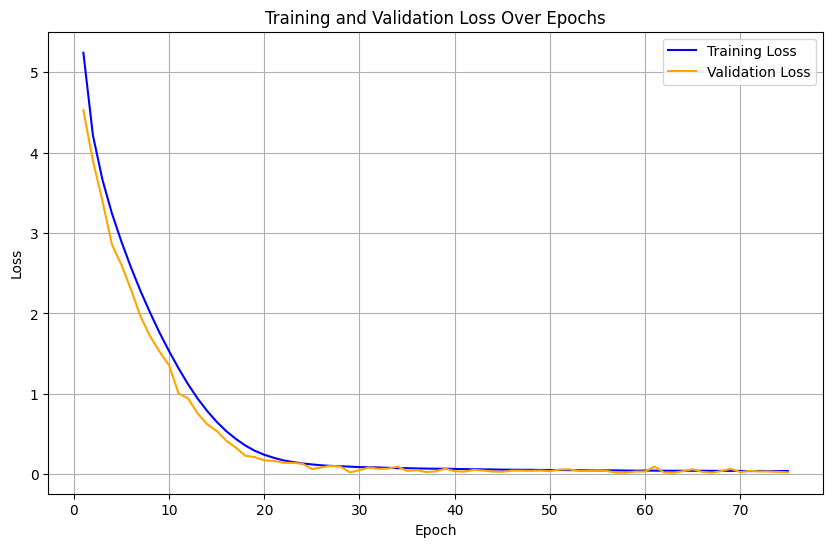

In [19]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **Save the final model**

In [20]:

# Save the final model
torch.save({
    'model_state_dict': transformer_model.state_dict(),
    'src_vocab': src_vocab,
    'tgt_vocab': tgt_vocab,
    'model_config': {
        'input_vocab_size': input_vocab_size,
        'output_vocab_size': output_vocab_size,
        'model_dim': model_dim,
        'num_heads': num_heads,
        'num_layers': num_layers,
        'hidden_dim': hidden_dim,
        'max_len': max_len,
        'dropout_rate': dropout_rate
    }
}, 'transformer_ar_en_final.pt')

In [21]:
checkpoint = torch.load("transformer_ar_en_final.pt", map_location=device, weights_only=False)
config = checkpoint['model_config']
model = TransformerModel(
    config['input_vocab_size'], config['output_vocab_size'],
    config['model_dim'], config['num_heads'], config['num_layers'],
    config['hidden_dim'], config['max_len'], config['dropout_rate']
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
src_vocab = checkpoint['src_vocab']
tgt_vocab = checkpoint['tgt_vocab']
test_dataloader, _, _, _, _ = prepare_data(batch_size=32)

Loading and preprocessing data...


# **INFERENCE EXAMPLE**

In [22]:
def translate_sentence(sentence, src_vocab, tgt_vocab, model, max_len=100):
    model.eval()
    sentence = re.sub(r'[^\w\s]', '', sentence.lower())  # Clean punctuation
    tokens = ['<sos>'] + sentence.strip().split() + ['<eos>']
    input_ids = [src_vocab.get(tok, src_vocab['<unk>']) for tok in tokens]
    src_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    tgt_ids = [tgt_vocab['<sos>']]
    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_ids).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)
        next_token = torch.argmax(output[0, -1, :]).item()
        tgt_ids.append(next_token)
        if next_token == tgt_vocab['<eos>']:
            break
    idx2word = {i: w for w, i in tgt_vocab.items()}
    return ' '.join([
        idx2word.get(i, '') 
        for i in tgt_ids[1:] 
        if i not in [0, tgt_vocab['<eos>'], tgt_vocab['<unk>']]
    ])

In [23]:
def compute_bleu(model, dataloader, src_vocab, tgt_vocab, num_samples=100):
    model.eval()
    total_score = 0
    count = 0
    idx2src = {i: w for w, i in src_vocab.items()}
    idx2tgt = {i: w for w, i in tgt_vocab.items()}
    smoother = SmoothingFunction().method1
    for src_batch, tgt_batch in dataloader:
        src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
        for src, tgt in zip(src_batch, tgt_batch):
            src = [i for i in src.tolist() if i != 0]
            tgt = [i for i in tgt.tolist() if i not in [0, tgt_vocab['<sos>'], tgt_vocab['<eos>'], tgt_vocab['<unk>']]]
            src_sentence = ' '.join([idx2src[i] for i in src if i not in [src_vocab['<unk>']]])
            ref = [' '.join([idx2tgt[i] for i in tgt])]
            pred = translate_sentence(src_sentence, src_vocab, tgt_vocab, model)
            score = sentence_bleu([ref[0].split()], pred.split(), smoothing_function=smoother)
            total_score += score
            count += 1
            if count >= num_samples:
                return total_score / count
    return total_score / count

In [24]:
def print_random_arabic_examples(model, src_vocab, tgt_vocab):
    examples = [
        "ما الساعة الآن؟",
        "أحب البرمجة.",
        "هذا الكتاب ممتع جدا.",
        "هل يمكنك مساعدتي من فضلك؟",
        "الطقس لطيف اليوم.",
        "استعجل، توم!",
        "توقف، أنا حزين.",
        "أنا سعيد لرؤيتك مجددا.",
        "توم ينتظرك في المنزل.",
        "تفضل واجلس.",
        "لنذهب إلى الحديقة هذا المساء.",
        "إنها تحب الرقص في الحفلات.",
        "إنه طبيب ولطيف جدا.",
        "أريد قراءة المزيد من الكتب هذا العام.",
        "الطيور تغني بشكل جميل في الصباح.",
        "نحتاج إلى مساعدة لحل هذه المشكلة.",
        "يجب أن تحاول أن تكون أكثر إبداعا."
    ]
    print("Random Arabic Sentences with Translations:")
    for sentence in examples:
        translation = translate_sentence(sentence, src_vocab, tgt_vocab, model)
        print(f"\nExample Translation:\nAR: {sentence}\nEN: {translation}")


In [25]:
def run_test():
    print("Testing BLEU score on 1000 samples...")
    bleu = compute_bleu(model, test_dataloader, src_vocab, tgt_vocab, num_samples=1000)
    print(f"\nAverage BLEU score: {bleu:.4f}")
    print_random_arabic_examples(model, src_vocab, tgt_vocab)

run_test()

Testing BLEU score on 1000 samples...

Average BLEU score: 0.6381
Random Arabic Sentences with Translations:

Example Translation:
AR: ما الساعة الآن؟
EN: what time is it

Example Translation:
AR: أحب البرمجة.
EN: i love

Example Translation:
AR: هذا الكتاب ممتع جدا.
EN: this book is very interesting

Example Translation:
AR: هل يمكنك مساعدتي من فضلك؟
EN: can you help me please

Example Translation:
AR: الطقس لطيف اليوم.
EN: that kind of weather today

Example Translation:
AR: استعجل، توم!
EN: tom made me angry

Example Translation:
AR: توقف، أنا حزين.
EN: stop im not your

Example Translation:
AR: أنا سعيد لرؤيتك مجددا.
EN: im glad to see you again

Example Translation:
AR: توم ينتظرك في المنزل.
EN: tom is waiting to study home

Example Translation:
AR: تفضل واجلس.
EN: heres your order

Example Translation:
AR: لنذهب إلى الحديقة هذا المساء.
EN: lets go to this the park

Example Translation:
AR: إنها تحب الرقص في الحفلات.
EN: she likes to dance

Example Translation:
AR: إنه طبيب ولطيف 